In [1]:
import spectre
import spectre.IO.H5 as spectre_h5
from spectre.Spectral import Mesh, Basis, Quadrature, logical_coordinates
from spectre.DataStructures import DataVector, Index
from spectre.DataStructures.Tensor import InverseJacobian, Jacobian, Scalar, tnsr
from spectre.NumericalAlgorithms.LinearOperators import power_monitors
import spectre.Evolution.DgSubcell as scl
import spectre.IO.H5 as h5

from matplotlib import pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib
import matplotlib.animation
import numpy as np

# Set the path to the spectre bin directory. We will use this later for running executables.
from pathlib import Path;
spectre_bin_path = str(Path(spectre.__file__).parent.parent.parent)

# Set up the path to the notebook. We assume input files are next to the notebook.
import os
notebook_path = os.getcwd()

# Discontinuous Galerkin-Finite Difference hybrid method

The goal of this notebook is to introduce the DG-FD hybrid method, including key ideas like how to decide when to switch back and forth between the two methods.

DG or spectral methods work very well for smooth solutions. However, simulations of hydrodynamical flows have discontinuities and shocks which are difficult to handle with DG methods. While a number of strategies have been proposed in the literature, our experience has been that these are not generally robust enough for scientific applications. Instead, we supplement a DG method with a FD in regions where there are shocks. This allows us to gain the shock capturing capabilities of FD methods, which have a decades-long and rich history of development, with high-order accuracy and efficiency in smooth regions. You've already learned about DG methods, so we will briefly review FD methods and then discuss how we couple DG and FD together.

We divide each DG element into multiple FD cells, which we often refer to as subcells. For FD methods we denote the frame in which the cell is Cartesian with a hat
over the indices and the coordinates as $\{\xi,\eta,\zeta\}$. In order to support FD on curved meshes SpECTRE now solves the
equations in the form
$$
  \frac{\partial u}{\partial t}
  + \frac{1}{J}\partial_{\hat{\imath}}
  \left[
  J\frac{\partial \xi^{\hat{\imath}}}{\partial x^i}
  \left(F^i-u v^i_g\right)\right]
  = S - u\partial_i v^i_g,
    \tag{1}
$$
where $v^i_g$ is the grid or mesh velocity and we can identify
$F^{\hat{\imath}}=J\frac{\partial \xi^{\hat{\imath}}}{\partial x^i} F^i$ as the
"locally Cartesian flux" in the reference coordinates. This is analogous to
how DG schemes are formulated\cite{Teukolsky:2015ega, Deppe:2021ada}. In
practice we compute the mesh velocity divergence on the DG grid and project it
to the FD grid. While this form is somewhat different from the strong form used
by our DG solver, we can still rewrite the equations in a form that naturally
hybridizes with a DG solver. In particular, the boundary corrections $G$ in a DG
scheme are essentially $n_iF^i$ where $n_i$ is the normal covector to the
spatial element interface and in the logical $\hat{\imath}$ direction is given
by
$$
  n^{(\hat{\imath})}_i=\frac{\partial \xi^{(\hat{\imath})}}{\partial x^i}
  \frac{1}{\sqrt{\frac{\partial \xi^{(\hat{\imath})}}{\partial x^j}
  \gamma^{jk}\frac{\partial \xi^{(\hat{\imath})}}{\partial x^k}}}
  =J\frac{\partial \xi^{(\hat{\imath})}}{\partial x^i}
  \frac{1}{\sqrt{J\frac{\partial \xi^{(\hat{\imath})}}{\partial x^j}
  \gamma^{jk}J\frac{\partial \xi^{(\hat{\imath})}}{\partial x^k}}}.
  \tag{2}
$$
With $G^{(\hat{\imath})}$ as the boundary correction or numerical flux at the
interface in direction $\hat{\imath}$, possibly including a high-order
correction\cite{DelZanna:2007pk, Most:2019kfe}, we can write the discretized FD
evolution equation as
\begin{align}
  \frac{\partial u_{(\xi,\eta,\zeta)}}{\partial t} &= S_{(\xi,\eta,\zeta)}
  -u_{(\xi,\eta,\zeta)} \mathcal{P}(\partial_i v^i_g)_{(\xi,\eta,\zeta)}
  \nonumber \\
  &- \frac{1}{J_{(\xi,\eta,\zeta)}}\left[
    \frac{\left(|n^{(\hat{\xi})}|G^{\hat{(\xi)}}\right)_{(\xi +
    1/2,\eta,\zeta)}
    -\left(|n^{(\hat{\xi})}|G^{\hat{(\xi)}}\right)_{(\xi - 1/2,\eta,\zeta)}
    }{\Delta \xi}\right.\nonumber\\
  &\left.+
    \frac{\left(|n^{(\hat{\eta})}|G^{\hat{(\eta)}}\right)_{(\xi,\eta +
    1/2,\zeta)}
    -\left(|n^{(\hat{\eta})}|G^{\hat{(\eta)}}\right)_{(\xi,\eta - 1/2,\zeta)}
    }{\Delta \eta}
    \right.\nonumber\\
  &\left.+
    \frac{\left(|n^{(\hat{\zeta})}|G^{\hat{(\zeta)}}\right)_{(\xi,\eta,\zeta +
    1/2)}
    -\left(|n^{(\hat{\zeta})}|G^{\hat{(\zeta)}}\right)_{(\xi,\eta,\zeta -
    1/2)}
    }{\Delta \zeta}
    \right],
    \tag{3}
\end{align}
where $\mathcal{P}$ is the projection operator from the DG to the FD grid as
defined in\cite{Deppe:2021ada} and
$|n^{(\hat{\imath})}|=\sqrt{J\frac{\partial \xi^{(\hat{\imath})}}{\partial
    x^j}\gamma^{jk}J\frac{\partial \xi^{(\hat{\imath})}}{\partial x^k}}$ or
$|n^{(\hat{\imath})}|=\sqrt{\frac{\partial \xi^{(\hat{\imath})}}{\partial
    x^j}\gamma^{jk}\frac{\partial \xi^{(\hat{\imath})}}{\partial x^k}}$ depending
on which normal vector form is chosen. Since the correction $G^{(\hat{\imath})}$
is exactly what is used in a DG scheme we can straightforwardly hybridize the
two schemes in a conservative manner, independent of the exact DG or FD
formulation used. The primary reason for using this discretized form is for easier
implementation on curved meshes since in this form the equations are simply the
standard Cartesian evolution equations.

For pedagogical reasons we will focus on Cartesian meshes in this tutorial, but all
of the concepts generalize to curved meshes. We will, however, use the form of the
equations that generalizes.

### 1. Setting up the mesh

As a first step we will set up a 1d DG mesh that uses $N$ Legendre-Gauss-Lobatto points. We then compute the DG logical coordinates. For simplicity we will only work with the logical coordinates and not a coordinate map. This will be sufficient to illustrate the main points.

In [2]:
dg_mesh = Mesh[1](20, Basis.Legendre, Quadrature.GaussLobatto)
dg_logical_coords = logical_coordinates(dg_mesh)
print(dg_logical_coords)

T(0)=(-1,-0.980744,-0.935934,-0.866878,-0.775368,-0.663776,-0.534993,-0.392353,-0.239552,-0.0805459,0.0805459,0.239552,0.392353,0.534993,0.663776,0.775368,0.866878,0.935934,0.980744,1)


Now that we have we have the DG mesh we need to compute the associated FD mesh. So what is the "correct" FD mesh to use? Since FD methods are most easily formulated on evenly spaced grids, this means we want $M$ evenly spaced FD grid points. One option is to use the same number of FD and DG grid points. However, if we look at the maximum allowed time step size based on the CFL/Courant condition, for DG we have
$$
\Delta t \le \frac{1}{D(2N-1)}\frac{\Delta x_{\mathrm{element}}}{\lambda_\mathrm{max}}
\tag{4}
$$
where $D$ is the number of spatial dimensions, $\Delta x_{\mathrm{element}}$ the size of the DG element, and $\lambda_\mathrm{max}$ the maximum characteristic speed (i.e. the speed information is traveling at across the grid). For FD schemes the CFL/Courant condition is
$$
\Delta t \le \frac{1}{D}\frac{\Delta x_{\mathrm{cell}}}{\lambda_\mathrm{max}}
\tag{5}
$$
where $\Delta x_{\mathrm{cell}}$ is the size of an FD cell.

Comparing these two conditions we see that we can use $M=2N-1$ FD grid points for the same time step size. This is what we do in SpECTRE. We compute the FD mesh associated with a DG mesh and the FD logical coordinates below.

In [4]:
fd_mesh = scl.mesh(dg_mesh)
fd_logical_coords = logical_coordinates(fd_mesh)
print(fd_logical_coords)

T(0)=(-0.974359,-0.923077,-0.871795,-0.820513,-0.769231,-0.717949,-0.666667,-0.615385,-0.564103,-0.512821,-0.461538,-0.410256,-0.358974,-0.307692,-0.25641,-0.205128,-0.153846,-0.102564,-0.0512821,-1.38778e-17,0.0512821,0.102564,0.153846,0.205128,0.25641,0.307692,0.358974,0.410256,0.461538,0.512821,0.564103,0.615385,0.666667,0.717949,0.769231,0.820513,0.871795,0.923077,0.974359)


Let's print the DG and FD mesh to compare.

In [5]:
print(dg_mesh, fd_mesh)

[(20),(Legendre),(GaussLobatto)] [(39),(FiniteDifference),(CellCentered)]


We see that the FD mesh does indeed have $M=2N-1$ grid points.

Finally, let's plot the solution $y=0$ on the DG grid and $y=1$ on the FD grid to see how the points compared.

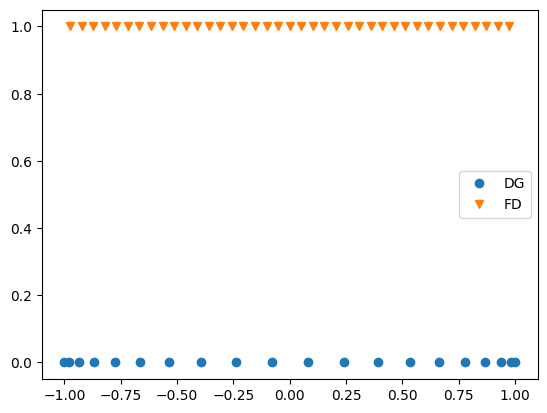

In [6]:
plt.plot(dg_logical_coords.get(0), np.full((dg_mesh.extents(0)), 0.0), marker='o', linestyle='', label="DG")
plt.plot(fd_logical_coords.get(0), np.full((fd_mesh.extents(0)), 1.0), marker='v', linestyle='', label="FD")
plt.legend()
plt.show()

We can see that the DG grid points are clustered towards the end points ($-1$ and $1$), while the FD grid points are uniformly spaced. Note that we use cell-centered FD grids, so there is no FD grid point at $-1$ or $1$.

### 2. Troubled Cell Indicators

One of the most challenging parts of the DG-FD hybrid approach is deciding when it switch. While the details can get a bit complicated for the GRMHD system, the high level ideas are more straightforward. We can divide the troubled cell indicators (TCIs) into two classes
1. Numerical: e.g. how oscillatory the solution is, how much it changes from one time step to the next
2. Physical: e.g. is the density positive, can we recover the primitve variables, are speeds subluminal

In practice a combination of both classes are used, typically in order of cheapest to most expensive to evaluate. The physical criteria depend on the physical system being considered, while the numerical ones are very general. An example that has been very successful is the Persson indicator, which will be the only one we discuss. Consider a discontinuity sensing
quantity $u$, which is typically a scalar like the rest mass density but could be a tensor of any rank. Let
$u$ have the 1d spectral decomposition:
$$
u(x)=\sum_{i=0}^{N-1}c_i P_i(x),
\tag{6}
$$
where in our case $P_i(x)$ are Legendre polynomials, and $c_i$ are the spectral
coefficients. The Persson TCI essentially
monitors the percentage of power in the highest spectral coefficient(s). To do
this, we define $\hat{u}$ as
\begin{eqnarray}
  \hat{u}(x)=c_{N-1} P_{N-1}(x).
\end{eqnarray}
and check that
\begin{eqnarray}
  N^\alpha \sqrt{\sum_{{\hat{\imath}}=0}^{N-1} \hat{u}_{\hat{\imath}}^2} >
  \sqrt{\sum_{{\hat{\imath}}=0}^{N-1}
  u_{\hat{\imath}}^2},
\end{eqnarray}
where $N^\alpha$ can be precomputed and stored. Note that we find that this
mathematically equivalent condition to our previous check\cite{Deppe:2021ada},
\begin{eqnarray}
  s^\Omega=\log_{10}\left(\sqrt{\frac{\sum_{{\hat{\imath}}=0}^{N-1}
  \hat{u}_{\hat{\imath}}^2}{\sum_{{\hat{\imath}}=0}^{N-1}
  u_{\hat{\imath}}^2}}\right) <s^e=-\alpha_N\log_{10}(N),
\end{eqnarray}
is cheaper and better behaved in the limit of $u\to0$.

Let's make some plots to get some intuition for what the Persson TCI looks. We will plot spectral coefficients for $\sin(x)$ and a Heaviside step function $\Theta(x)$, plus a few different curves for the Persson TCI with different values of $\alpha$. For the Persson TCI we plot $1/(i+1)^\alpha$ where $i$ is the index of the spectral coefficient. Larger values of $\alpha$ ultimately make the Persson TCI permit larger oscillations in the DG solution before switching to FD.

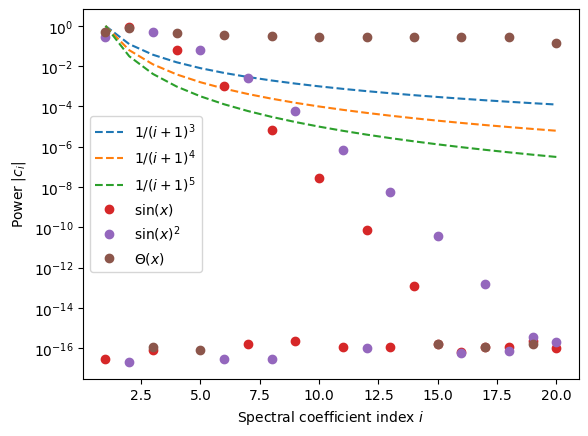

In [7]:
n = np.arange(1, dg_mesh.extents(0)+1)
for i in range(3, 6):
    plt.semilogy(n, 1/n**i, '--', label=f"$1 / (i+1)^{i}$")
# We call sin and step_function on DataVectors as member functions.
# You can also do DataVector.sin(dg_logical_coords.get(0))
#
# The power_monitors function https://spectre-code.org/group__SpectralGroup.html#gacf0041727af6a4a03fa05f0a5850cead
# is used to compute the spectral coefficients.
plt.semilogy(n, power_monitors(dg_logical_coords.get(0).sin(), dg_mesh)[0], marker='o', linestyle='',
            label="$\sin(x)$")
plt.semilogy(n, power_monitors(dg_logical_coords.get(0).sin()**2, dg_mesh)[0], marker='o', linestyle='',
            label="$\sin(x)^2$")
plt.semilogy(n, power_monitors(dg_logical_coords.get(0).step_function(), dg_mesh)[0], marker='o', linestyle='',
            label="$\Theta(x)$")
plt.ylabel("Power $|c_i|$")
plt.xlabel("Spectral coefficient index $i$")
plt.legend()
plt.show()

Quiz: Why are there so many modes that are zero?

There are several important things to note:
1. The Heavidside step function $\Theta(x)$ has spectral coefficients that don't decay. This is a typical feature of discontinuous solutions. This means that increasing the number of basis functions does not decrease the numerical error, since for spectral methods the coefficients should decay exponentially.
2. The spectral coefficients for the $\sin(x)$ and $\sin(x)^2$ solutions decay exponentially towards machine precision, $10^{-16}$. This indicates the solution is smooth and can be accurately represented by a spectral method.
3. Increasing $\alpha$ moves the dashed lines that demonstrate the Persson TCI sensitivity downward. Essentially, a solution is considered admissible or okay if it's highest spectral coefficient (or the highest several) are below the dashed line.
4. Given the previous definition of a solution being admissible, we can see that even a sine wave, which is smooth, can be determined to be inadmissible if we use too few grid points. This is because we care about whether or not the feature is resolved on the grid, not whether or not the solution is in theory smooth. That is, anything that is underresolved effectively appears as a discontinuity ond so cannot be accurately represented using a spectral method like DG.
5. We have a lot of modes that are $0$. This is because the solution is (anti)symmetric about $x=0$. In a realistic simulation this would not be the case.

Let's now plot the three functions to get some idea of what they look like on our grid.

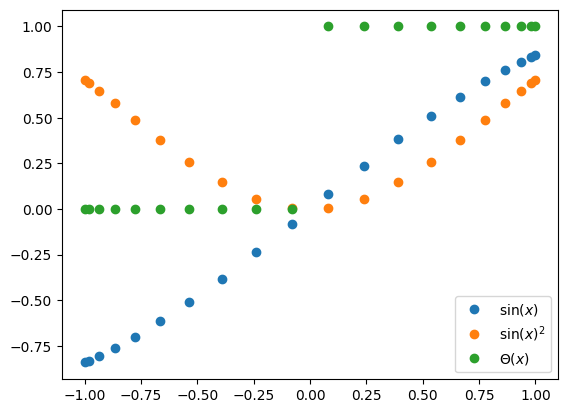

In [8]:
plt.plot(dg_logical_coords.get(0), dg_logical_coords.get(0).sin(), marker='o', linestyle='',
            label="$\sin(x)$")
plt.plot(dg_logical_coords.get(0), dg_logical_coords.get(0).sin()**2, marker='o', linestyle='',
            label="$\sin(x)^2$")
plt.plot(dg_logical_coords.get(0), dg_logical_coords.get(0).step_function(), marker='o', linestyle='',
            label="$\Theta(x)$")
plt.legend()
plt.show()

As a final example, let's run the Persson TCI on the above functions.

In [9]:
print("sin(x)^2 is troubled:", scl.persson_tci(Scalar[DataVector](dg_logical_coords.get(0).sin()**2), dg_mesh, 4.0, 1))
print("Theta(x) is troubled:", scl.persson_tci(Scalar[DataVector](dg_logical_coords.get(0).step_function()), dg_mesh, 4.0, 1))

sin(x)^2 is troubled: False
Theta(x) is troubled: True


Now let's try running the TCI on a lower resolution grid, say 5 points.

In [10]:
print("sin(x)^2 is troubled:", scl.persson_tci(Scalar[DataVector](logical_coordinates(
    Mesh[1](5, Basis.Legendre, Quadrature.GaussLobatto)).get(0).sin()**2),
                                              Mesh[1](5, Basis.Legendre, Quadrature.GaussLobatto), 4.0, 1))

sin(x)^2 is troubled: True


We now see that the solution is found to be troubled by the Persson TCI. This shows we will switch to FD on solutions that are not resolved by the DG scheme and therefore effectively look discontinuous or non-smooth.

### 3. Switching between DG and FD

Once we've determined that a DG solution is bad we undo the last time (or substep with Runge-Kutta methods) that we took. We then need to take the solution on the DG grid and interpolate it to the FD grid. One important aspect is that the projection operation is conservative. This can be guaranteed by using an $L_2$ projection, which minimizes the integral
$$
  \int_{-1}^{1}\left(u-\underline{u}\right)^2\,dx =
$$
with respect to $\underline{u}$, where $\underline{u}$ is the solution on the FD subcells. In practice we find that projection is equivalent to interpolation in this context and so straightforward spectral interpolation should be used.

First, let's project the DG logical coordinates to the FD grid, then subtract the FD logical coordinates from it. If they are the same the result will be around machine precision.

In [11]:
diff_coords = DataVector(scl.project(dg_logical_coords.get(0), dg_mesh, Index[1](fd_mesh.extents())) - fd_logical_coords.get(0))
max_diff_coords = diff_coords.abs().max()
print(max_diff_coords)

3.3306690738754696e-16


We see that the maximum difference between the projected DG coordinates and the FD logical coordinates is $\mathcal{O}(10^{-16})$, so they agree.

Next let's project the sinusoidal solutions to the FD grid and plot them.

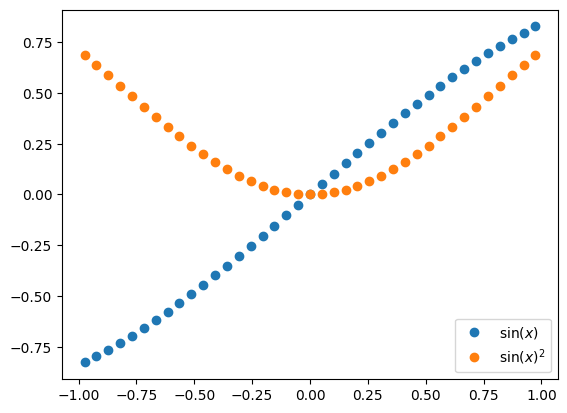

In [12]:
fd_sin = scl.project(dg_logical_coords.get(0).sin(), dg_mesh, Index[1](fd_mesh.extents()))
fd_sin2 = scl.project(dg_logical_coords.get(0).sin()**2, dg_mesh, Index[1](fd_mesh.extents()))
plt.plot(fd_logical_coords.get(0), fd_sin, marker='o', linestyle='', label="$\sin(x)$")
plt.plot(fd_logical_coords.get(0), fd_sin2, marker='o', linestyle='', label="$\sin(x)^2$")
plt.legend()
plt.show()

We can see that the both $\sin(x)$ and the $\sin(x)^2$ projected solutions look reasonable. Let's quantify this by plotting the difference between the projected and computed solutions on the FD grid.

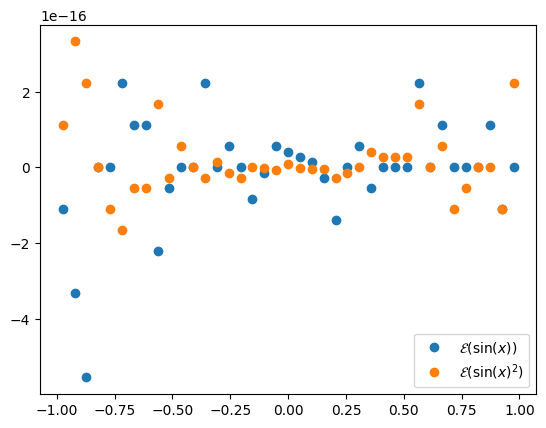

In [13]:
plt.plot(fd_logical_coords.get(0), fd_sin-fd_logical_coords.get(0).sin(), marker='o', linestyle='', label="$\mathcal{E}(\sin(x))$")
plt.plot(fd_logical_coords.get(0), fd_sin2-fd_logical_coords.get(0).sin()**2, marker='o', linestyle='', label="$\mathcal{E}(\sin(x)^2)$")
plt.legend()
plt.show()

We see that the projected solution agrees with the analytical one to machine, demonstrating that the projection routines are correct.

Now let's project the step function solution and plot that.

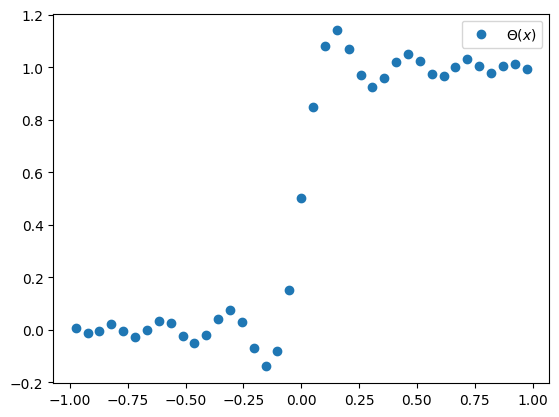

In [14]:
fd_step = scl.project(dg_logical_coords.get(0).step_function(), dg_mesh, Index[1](fd_mesh.extents()))
plt.plot(fd_logical_coords.get(0), fd_step, marker='o', linestyle='', label="$\Theta(x)$")
plt.legend()
plt.show()

What we observe is an unphysical ringing in the solution known as Gibbs phenomenon. This shows that the DG solution doesn't represent step functions accurately. Looking back at the plot of the spectral modes, this is also visible from the spectral modes not decaying exponentially. The higher modes are very oscillatory and so should be small corrections to the solutions. Since they aren't here, we see very poor interpolation. What this tells us is that we need to interpolate to the FD grid **before** any discontinuities enter our DG element.

Now that we've looked at switching from DG to FD, we can do the inverse. Specifically, we want the property that the restriction operator $\mathcal{R}$ from FD to DG is the inverse of the projection operator $\mathcal{P}$. That is, $\mathcal{R}(\mathcal{P})=\mathcal{I}$ where $\mathcal{I}$ is the identity. Ultimately this is achieved by having $\mathcal{R}$ be the pseudo-inverse of $\mathcal{P}$ computed from a constrained linear least squares problem where the constraint is that the integral over the FD grid and DG grid are the same. Deriving the $\mathcal{R}$ operator/matrix is quite involved\cite{}. As a first test of how well our restriction operator works, let's restrict the step function solution back to the DG grid and plot it.

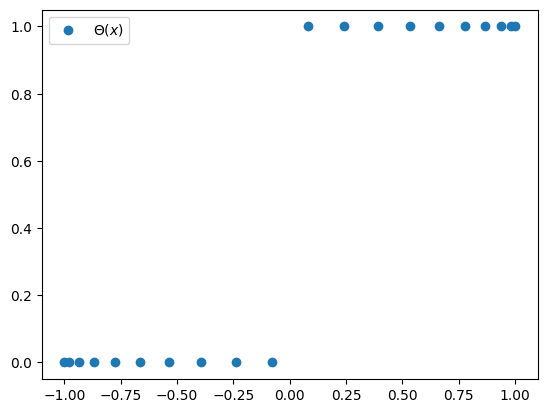

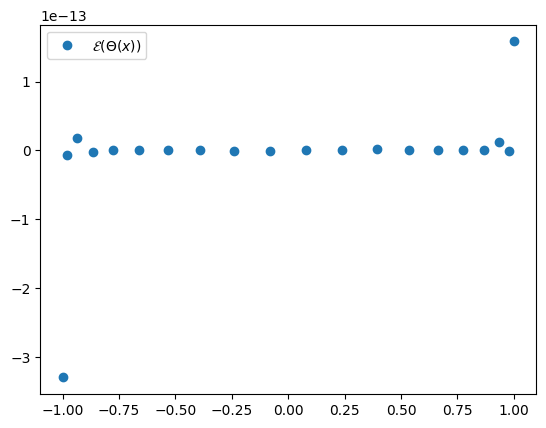

In [15]:
dg_step = scl.reconstruct(fd_step, dg_mesh, Index[1](fd_mesh.extents()), scl.FdReconstructionMethod.DimByDim)
plt.plot(dg_logical_coords.get(0), dg_step, marker='o', linestyle='', label="$\Theta(x)$")
plt.legend()
plt.show()

plt.plot(dg_logical_coords.get(0), dg_step - dg_logical_coords.get(0).step_function(),
         marker='o', linestyle='', label="$\mathcal{E}(\Theta(x))$")
plt.legend()
plt.show()

While there are some numerical errors at the boundaries, they are extremely small. This is quite impressive considering we are working with a discontinuous solution. Next let's look at the two $\sin$ solutions.

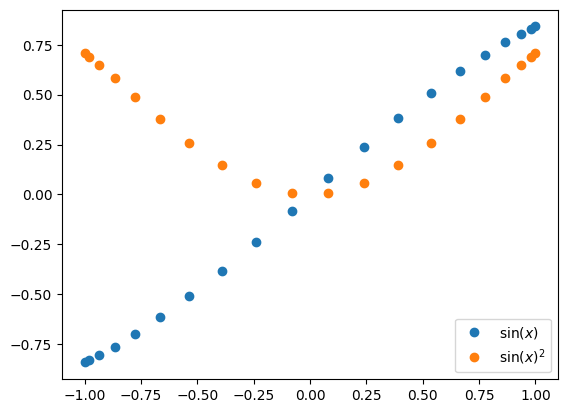

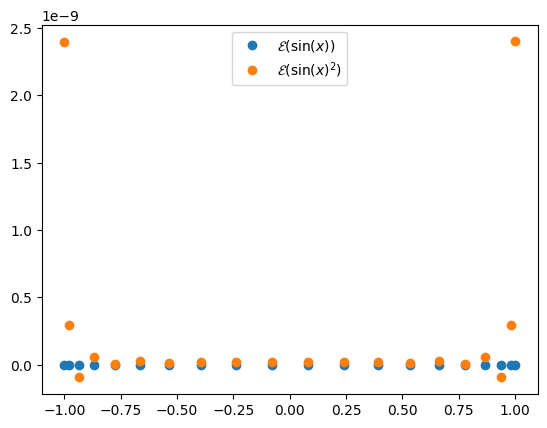

In [16]:
dg_sin = scl.reconstruct(fd_sin, dg_mesh, Index[1](fd_mesh.extents()), scl.FdReconstructionMethod.DimByDim)
dg_sin2 = scl.reconstruct(fd_sin2, dg_mesh, Index[1](fd_mesh.extents()), scl.FdReconstructionMethod.DimByDim)
plt.plot(dg_logical_coords.get(0), dg_sin, marker='o', linestyle='', label="$\sin(x)$")
plt.plot(dg_logical_coords.get(0), dg_sin2, marker='o', linestyle='', label="$\sin(x)^2$")
plt.legend()
plt.show()

plt.plot(dg_logical_coords.get(0), dg_sin - dg_logical_coords.get(0).sin(),
         marker='o', linestyle='', label="$\mathcal{E}(\sin(x))$")
plt.plot(dg_logical_coords.get(0), dg_sin2 - dg_logical_coords.get(0).sin()**2,
         marker='o', linestyle='', label="$\mathcal{E}(\sin(x)^2)$")
plt.legend()
plt.show()

Again we see quite good agreement, though not perfect, between the two solutions. The reason the agreement isn't perfect is because SpECTRE currently always uses sixth-order integration weights on the FD grid. Changing the DG mesh for 20 to 6 gives machine-precision accuracy in the restriction. Let's verify this.

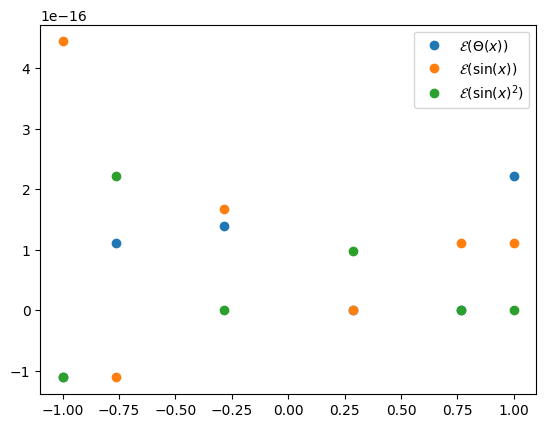

In [17]:
dg_mesh6 = Mesh[1](6, Basis.Legendre, Quadrature.GaussLobatto)
dg_logical_coords6 = logical_coordinates(dg_mesh6)
fd_mesh6 = scl.mesh(dg_mesh6)
fd_logical_coords6 = logical_coordinates(fd_mesh6)
fd_step6 = scl.project(dg_logical_coords6.get(0).step_function(), dg_mesh6, Index[1](fd_mesh6.extents()))
dg_step6 = scl.reconstruct(fd_step6, dg_mesh6, Index[1](fd_mesh6.extents()), scl.FdReconstructionMethod.DimByDim)


plt.plot(dg_logical_coords6.get(0), dg_step6 - dg_logical_coords6.get(0).step_function(),
         marker='o', linestyle='', label="$\mathcal{E}(\Theta(x))$")
plt.plot(dg_logical_coords6.get(0), scl.reconstruct(scl.project(dg_logical_coords6.get(0).sin(),
                                                               dg_mesh6, Index[1](fd_mesh6.extents())),
                                                   dg_mesh6, Index[1](fd_mesh6.extents()),
                                                   scl.FdReconstructionMethod.DimByDim) - dg_logical_coords6.get(0).sin(),
         marker='o', linestyle='', label="$\mathcal{E}(\sin(x))$")
plt.plot(dg_logical_coords6.get(0), scl.reconstruct(scl.project(dg_logical_coords6.get(0).sin()**2,
                                                               dg_mesh6, Index[1](fd_mesh6.extents())),
                                                   dg_mesh6, Index[1](fd_mesh6.extents()),
                                                   scl.FdReconstructionMethod.DimByDim) - dg_logical_coords6.get(0).sin()**2,
         marker='o', linestyle='', label="$\mathcal{E}(\sin(x)^2)$")
plt.legend()
plt.show()

With this background, we are now ready to try running some simulations.

### 4. Running Burgers simulations with DG-FD

To provide a real-world example we will run two different Burgers simulations using the DG-FD hybrid method.

The first simulation we will run is the Step solution to Burgers equation. In this case a step function is advected from the left to the right. The documentation for the analytic solution class is https://spectre-code.org/classBurgers_1_1Solutions_1_1Step.html

In [18]:
! rm -f BurgersStep*h5
! $spectre_bin_path/EvolveBurgers --input-file=$notebook_path/Step.yaml

MPI startup(): FI_PSM3_UUID was not generated, please set it to avoid possible resources ownership conflicts between MPI processes
Charm++> Running on MPI version: 3.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in SMP mode: 1 processes, 1 worker threads (PEs) + 1 comm threads per process, 1 PEs total
Charm++> The comm. thread both sends and receives messages
Converse/Charm++ Commit ID: v7.0.0
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 32 cores x 1 PUs = 32-way SMP)
Charm++> cpu topology info is gathered in 0.001 seconds.

Executing 'EvolveBurgers' using 1 processors.
Launch command line: /home/fs01/nd357/spectre_build/clang_release/bin/EvolveBurgers --input-file=/home/fs01/nd357/spectre_build/Step.yaml
Charm++ startup time in seconds: 0.008097
Date and time at startup: Wed Jul 31 11:16:51 2024

SpECTRE Build Information:
Version:                      2024.06.18
Compiled on host:             mbot.cac.cornell.ed

In [19]:
burgers_step_file = h5.H5File("BurgersStepVolume0.h5", "r")
burgers_step_vol = burgers_step_file.get_vol("VolumeData.vol")
burgers_step_obs_ids = burgers_step_vol.list_observation_ids()
step_coords = [np.asarray(burgers_step_vol.get_tensor_component(burgers_step_obs_ids[obs_int], "InertialCoordinates_x").data).copy()
                  for obs_int in range(len(burgers_step_obs_ids))]
step_u = [np.asarray(burgers_step_vol.get_tensor_component(burgers_step_obs_ids[obs_int], "U").data).copy()
                  for obs_int in range(len(burgers_step_obs_ids))]
step_times = [burgers_step_vol.get_observation_value(burgers_step_obs_ids[obs_int])
              for obs_int in range(len(burgers_step_obs_ids))]
def plot_step_at(obs_int):
    plt.cla()
    plt.plot(step_coords[obs_int], step_u[obs_int], marker='o', linestyle='')
    plt.title(f"Time {step_times[obs_int]:1.2f}")

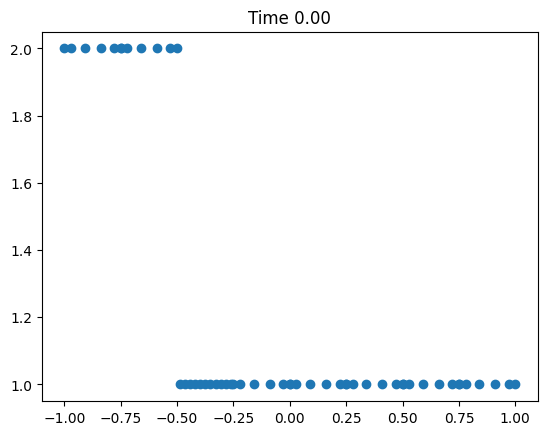

In [20]:
fig, ax = plt.subplots()
matplotlib.animation.FuncAnimation(fig, plot_step_at, frames=len(step_u))

Drag the slider or hit the Play button to watch the step solution propagate from the left to the right. You'll notice that as the discontinuity enters an element, the grid point spacing changes. This is the code switching from DG to FD. Similarly, as the discontinuity leaves an element the code switches from FD back to DG.

Next let's run a simulation of a periodic sinusoid solution that starts smooth and steepens over time to form a sawtooth wave. The documentation for the analytic solution class is https://spectre-code.org/classBurgers_1_1AnalyticData_1_1Sinusoid.html



In [21]:
! rm -f BurgersSinusoid*h5
! $spectre_bin_path/EvolveBurgers --input-file=$notebook_path/Sinusoid.yaml

MPI startup(): FI_PSM3_UUID was not generated, please set it to avoid possible resources ownership conflicts between MPI processes
Charm++> Running on MPI version: 3.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in SMP mode: 1 processes, 1 worker threads (PEs) + 1 comm threads per process, 1 PEs total
Charm++> The comm. thread both sends and receives messages
Converse/Charm++ Commit ID: v7.0.0
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 32 cores x 1 PUs = 32-way SMP)
Charm++> cpu topology info is gathered in 0.001 seconds.

Executing 'EvolveBurgers' using 1 processors.
Launch command line: /home/fs01/nd357/spectre_build/clang_release/bin/EvolveBurgers --input-file=/home/fs01/nd357/spectre_build/Sinusoid.yaml
Charm++ startup time in seconds: 0.005092
Date and time at startup: Wed Jul 31 11:17:00 2024

SpECTRE Build Information:
Version:                      2024.06.18
Compiled on host:             mbot.cac.cornel

In [22]:
burgers_sinusoid_file = h5.H5File("BurgersSinusoidVolume0.h5", "r")
burgers_sinusoid_vol = burgers_sinusoid_file.get_vol("VolumeData.vol")
burgers_sinusoid_obs_ids = burgers_sinusoid_vol.list_observation_ids()
sinusoid_coords = [np.asarray(burgers_sinusoid_vol.get_tensor_component(burgers_sinusoid_obs_ids[obs_int],
                                                                        "InertialCoordinates_x").data).copy()
                  for obs_int in range(len(burgers_sinusoid_obs_ids))]
sinusoid_u = [np.asarray(burgers_sinusoid_vol.get_tensor_component(burgers_sinusoid_obs_ids[obs_int],
                                                                   "U").data).copy()
                  for obs_int in range(len(burgers_sinusoid_obs_ids))]
sinusoid_times = [burgers_sinusoid_vol.get_observation_value(burgers_sinusoid_obs_ids[obs_int])
              for obs_int in range(len(burgers_sinusoid_obs_ids))]
def plot_sinusoid_at(obs_int):
    plt.cla()
    plt.plot(sinusoid_coords[obs_int], sinusoid_u[obs_int], marker='o', linestyle='')
    plt.title(f"Time {sinusoid_times[obs_int]:1.2f}")

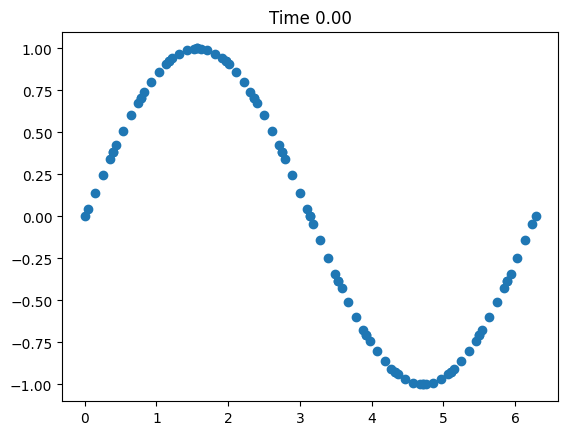

In [23]:
fig, ax = plt.subplots()
matplotlib.animation.FuncAnimation(fig, plot_sinusoid_at, frames=len(sinusoid_u))

We see that the solution starts as a smooth sinusoid and reaches a sawtooth shape at $t\sim1.8$. The solution then continues to steepen and decrease in amplitude until the final time of $t=3$. As the profile steepens the code switches from DG to FD at the center of the domain ($x=\pi$) and remains in that configuration throughout.

### 5. Running Newtonian hydrodynamics simulations with DG-FD

Now that we've looked at the Burgers system, let's look at a more physical example, Newtonian hydrodynamics. We will restrict ourselves to 1d to keep things quick to run and easy to visualize.  The Newtonian hydro equations are
$$
  \frac{\partial}{\partial t}
  \begin{pmatrix}
    \rho \\
    \rho v^i \\
    \rho E
  \end{pmatrix}
  + \partial_j
  \begin{pmatrix}
    \rho v^j \\
    \rho v^i v^j + p\delta^{ij} \\
    v^j(\rho E + p)
  \end{pmatrix}
  = 0,
$$
where
$$
p=(\gamma-1)\left(\rho E - \frac{1}{2}v^i v_i\right),
$$
and $v_i=\delta_{ij}v^j$. Our troubled cell indicator monitors both the density $\rho$ and the pressure $p$ since at contact discontinuities the pressure is continuous but the density is not. Monitoring the spatial velocity $v^i$ is more challenging since the velocity can reasonably be $0$.

The first test problem we will look at is called the Sod shock tube. This is a standard test problem in Newtonian hydrodynamics where a rarefaction waves travels leftward while a shock and contact discontiunity travel to the right. Below we plot the density as blue dots and the pressure as orange triangles. While this is not a particularly challenging test problem, it nicely shows the hybrid method switching between DG and FD. In this case we use the HLL (Harten-Lax-van Leer) approximate Riemann solver, which is commonly used in numerical relativity applications.

In [24]:
! rm -f NewtonianEulerSodVolume0.h5
! $spectre_bin_path/EvolveNewtonianEuler1D --input-file=$notebook_path/Sod.yaml

MPI startup(): FI_PSM3_UUID was not generated, please set it to avoid possible resources ownership conflicts between MPI processes
Charm++> Running on MPI version: 3.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in SMP mode: 1 processes, 1 worker threads (PEs) + 1 comm threads per process, 1 PEs total
Charm++> The comm. thread both sends and receives messages
Converse/Charm++ Commit ID: v7.0.0
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 32 cores x 1 PUs = 32-way SMP)
Charm++> cpu topology info is gathered in 0.001 seconds.

Executing 'EvolveNewtonianEuler1D' using 1 processors.
Launch command line: /home/fs01/nd357/spectre_build/clang_release/bin/EvolveNewtonianEuler1D --input-file=/home/fs01/nd357/spectre_build/Sod.yaml
Charm++ startup time in seconds: 0.007639
Date and time at startup: Wed Jul 31 11:17:09 2024

SpECTRE Build Information:
Version:                      2024.06.18
Compiled on host:             mb

In [25]:
ne_sod_file = h5.H5File("NewtonianEulerSodVolume0.h5", "r")
ne_sod_vol = ne_sod_file.get_vol("VolumeData.vol")
ne_sod_obs_ids = ne_sod_vol.list_observation_ids()
ne_sod_coords = [np.asarray(ne_sod_vol.get_tensor_component(ne_sod_obs_ids[obs_int],
                                                            "InertialCoordinates_x").data).copy()
                   for obs_int in range(len(ne_sod_obs_ids))]
ne_sod_rho = [np.asarray(ne_sod_vol.get_tensor_component(ne_sod_obs_ids[obs_int],
                                                          "RestMassDensity").data).copy()
                   for obs_int in range(len(ne_sod_obs_ids))]
ne_sod_p = [np.asarray(ne_sod_vol.get_tensor_component(ne_sod_obs_ids[obs_int],
                                                          "Pressure").data).copy()
                   for obs_int in range(len(ne_sod_obs_ids))]
ne_sod_times = [ne_sod_vol.get_observation_value(ne_sod_obs_ids[obs_int])
               for obs_int in range(len(ne_sod_obs_ids))]
def plot_ne_sod_at(obs_int):
    plt.cla()
    plt.plot(ne_sod_coords[obs_int], ne_sod_rho[obs_int], marker='o', linestyle='', label="$\rho$")
    plt.plot(ne_sod_coords[obs_int], ne_sod_p[obs_int], marker='^', linestyle='', label="$p$")
    plt.title(f"Time {ne_sod_times[obs_int]:1.2f}")


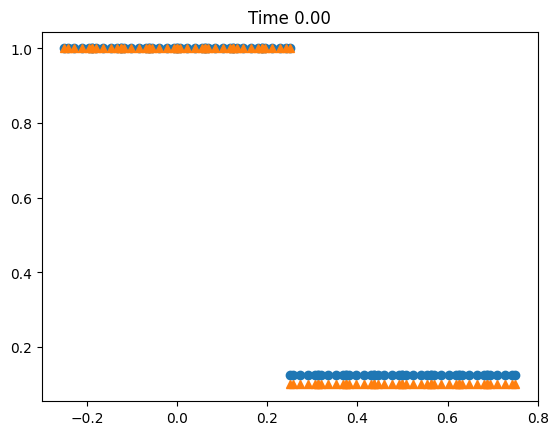

In [26]:
fig, ax = plt.subplots()
matplotlib.animation.FuncAnimation(fig, plot_ne_sod_at, frames=len(ne_sod_rho))

A slightly more challenging test problem is the Lax shock tube. This is very similar to the Sod shocktube except that the shock and contact discontinuity are more difficult to model.  Below we plot the density as blue dots and the pressure as orange triangles.  In this case we use the HLLC (Harten-Lax-van Leer+Contact) approximate Riemann solver.

In [27]:
! rm -f NewtonianEulerLaxVolume0.h5
! $spectre_bin_path/EvolveNewtonianEuler1D --input-file=$notebook_path/Lax.yaml

MPI startup(): FI_PSM3_UUID was not generated, please set it to avoid possible resources ownership conflicts between MPI processes
Charm++> Running on MPI version: 3.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in SMP mode: 1 processes, 1 worker threads (PEs) + 1 comm threads per process, 1 PEs total
Charm++> The comm. thread both sends and receives messages
Converse/Charm++ Commit ID: v7.0.0
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 32 cores x 1 PUs = 32-way SMP)
Charm++> cpu topology info is gathered in 0.001 seconds.

Executing 'EvolveNewtonianEuler1D' using 1 processors.
Launch command line: /home/fs01/nd357/spectre_build/clang_release/bin/EvolveNewtonianEuler1D --input-file=/home/fs01/nd357/spectre_build/Lax.yaml
Charm++ startup time in seconds: 0.005977
Date and time at startup: Wed Jul 31 11:17:19 2024

SpECTRE Build Information:
Version:                      2024.06.18
Compiled on host:             mb

In [28]:
ne_lax_file = h5.H5File("NewtonianEulerLaxVolume0.h5", "r")
ne_lax_vol = ne_lax_file.get_vol("VolumeData.vol")
ne_lax_obs_ids = ne_lax_vol.list_observation_ids()
ne_lax_coords = [np.asarray(ne_lax_vol.get_tensor_component(ne_lax_obs_ids[obs_int],
                                                            "InertialCoordinates_x").data).copy()
                   for obs_int in range(len(ne_lax_obs_ids))]
ne_lax_rho = [np.asarray(ne_lax_vol.get_tensor_component(ne_lax_obs_ids[obs_int],
                                                          "RestMassDensity").data).copy()
                   for obs_int in range(len(ne_lax_obs_ids))]
ne_lax_p = [np.asarray(ne_lax_vol.get_tensor_component(ne_lax_obs_ids[obs_int],
                                                          "Pressure").data).copy()
                   for obs_int in range(len(ne_lax_obs_ids))]
ne_lax_times = [ne_lax_vol.get_observation_value(ne_lax_obs_ids[obs_int])
               for obs_int in range(len(ne_lax_obs_ids))]
def plot_ne_lax_at(obs_int):
    plt.cla()
    plt.plot(ne_lax_coords[obs_int], ne_lax_rho[obs_int], marker='o', linestyle='', label="$\rho$")
    plt.plot(ne_lax_coords[obs_int], ne_lax_p[obs_int], marker='^', linestyle='', label="$p$")
    plt.title(f"Time {ne_lax_times[obs_int]:1.2f}")


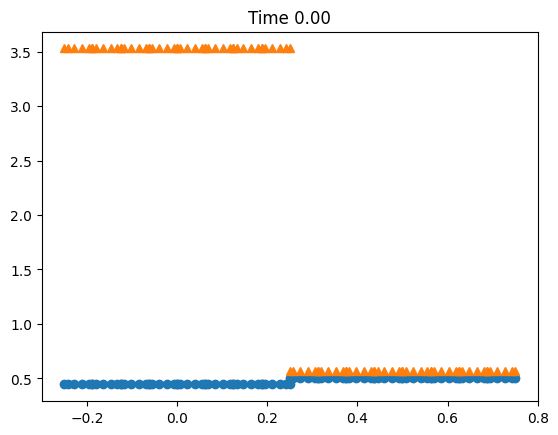

In [29]:
fig, ax = plt.subplots()
matplotlib.animation.FuncAnimation(fig, plot_ne_lax_at, frames=len(ne_lax_rho))